In [ ]:
import numpy as np
import random as python_random
import matplotlib.pyplot as plt
from time import time
from IPython.display import Javascript, display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    MaxPool2D,
    Dropout,
    BatchNormalization,
    Activation,
    GlobalAveragePooling2D,
    Dense,
    Flatten
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

We load the CIFAR-10 dataset and explore its main characteristics, such as dimensions and class distribution.


### Loading the CIFAR-10 dataset

In [ ]:
t0 = time()
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
print("Datasets downloaded in %0.2f seconds" % (time() - t0))

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Datasets downloaded in 6.39 seconds


### Dataset exploration

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [ ]:
X_train

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

The class labels are defined, and a helper function is used to analyze their distribution.  
 The dataset is balanced, with an equal number of images for each category.

In [ ]:
def analysis(dataset):
  unique, counts = np.unique(dataset, return_counts = True)
  for label, count in zip(unique, counts):
      print(f"Category {label + 1} has {count} images")

def display_image(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
print('Categories in training set:')
analysis(y_train)
print('\nCategories in test set:')
analysis(y_test)

Categories in training set:
Category 1 has 5000 images
Category 2 has 5000 images
Category 3 has 5000 images
Category 4 has 5000 images
Category 5 has 5000 images
Category 6 has 5000 images
Category 7 has 5000 images
Category 8 has 5000 images
Category 9 has 5000 images
Category 10 has 5000 images

Categories in test set:
Category 1 has 1000 images
Category 2 has 1000 images
Category 3 has 1000 images
Category 4 has 1000 images
Category 5 has 1000 images
Category 6 has 1000 images
Category 7 has 1000 images
Category 8 has 1000 images
Category 9 has 1000 images
Category 10 has 1000 images


we display a random image for a quick visual check.

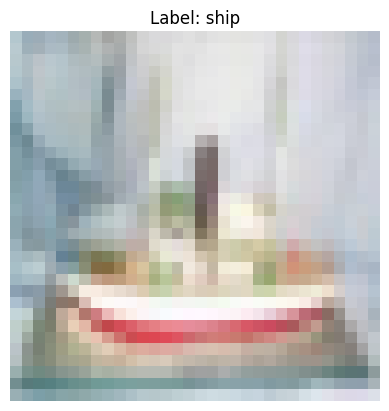

In [ ]:
index = np.random.randint(0, len(X_train))
display_image(X_train[index], labels[y_train[index][0]])

## Data pre-processing

We prepare the data for training.   
The pixel values of the images are normalized to the [0, 1] range,   
and the labels are converted to one-hot encoded format.

In [ ]:
X_train = X_train.astype('float32')/255.0 # Take values in [0,1]
X_test = X_test.astype('float32')/255.0

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

X_train[0], y_train[0]

(array([[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],
 
        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],
 
        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],
 
        ...,
 
        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333

In [ ]:
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

## CNN Model Development and Evaluation

We build and evaluate a series of Convolutional Neural Network (CNN) models with increasing complexity to identify the most promising architecture.

### BASE ARCHITECTURE:
We start with a simple CNN consisting of two convolutional layers and a dense layer. This model serves as a baseline for subsequent iterations.

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

<IPython.core.display.Javascript object>

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 814,378 (3.11 MB)

 Trainable params: 814,378 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=40,
    validation_data=(X_test, y_test),
)



<IPython.core.display.Javascript object>

Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4116 - loss: 1.6266 - val_accuracy: 0.5993 - val_loss: 1.1385
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6197 - loss: 1.0801 - val_accuracy: 0.6279 - val_loss: 1.0643
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6766 - loss: 0.9211 - val_accuracy: 0.6341 - val_loss: 1.0794
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7163 - loss: 0.8092 - val_accuracy: 0.6321 - val_loss: 1.1136
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7535 - loss: 0.7090 - val_accuracy: 0.6236 - val_loss: 1.2112
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7825 - loss: 0.6260 - val_accuracy: 0.6279 - val_loss: 1.2172
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8101 - loss: 0.5508 - val_accuracy: 0.6407 - val_loss: 1.2400
Epoch 8/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8360 - loss: 0.4779 -

<IPython.core.display.Javascript object>

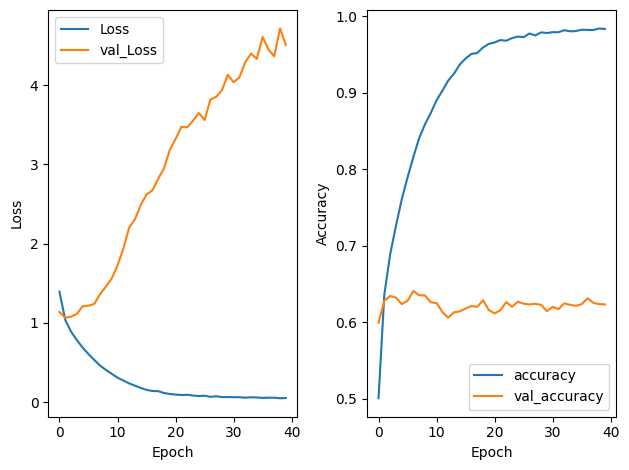

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
evaluation = model.evaluate(X_test, y_test)
print(f'Accuracy on test set : {evaluation[1] * 100:.2f}%')
print(f'Loss on test set : {evaluation[0] * 100:.2f}%')

<IPython.core.display.Javascript object>

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6323 - loss: 4.3813
Accuracy on test set : 62.31%
Loss on test set : 450.53%


The base model achieves an accuracy of ~62% on the test set. The learning curves show clear signs of severe overfitting, as the training accuracy approaches 100% while the validation accuracy stagnates and the validation loss increases.

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
Image 9845 is a(n) truck and the model predicts that it's a(n) truck


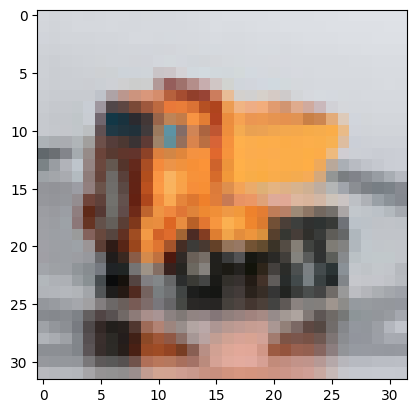

In [ ]:
index = np.random.randint(0, len(X_test))
image = X_test[index]
prediction = np.argmax(model.predict(image.reshape(1, 32, 32, 3)))
plt.imshow(image)

print(f"Image {index} is a(n) {labels[np.argmax(y_test[index])]} and the model predicts that it's a(n) {labels[prediction]}")

### Model 2: Increasing Depth

We increase the model's depth by adding a second convolutional block to see if it can capture more complex features and improve performance.

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
model.summary()

<IPython.core.display.Javascript object>

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,786 (1.04 MB)

 Trainable params: 271,786 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=40,
    validation_data=(X_test, y_test),
)


<IPython.core.display.Javascript object>

Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3818 - loss: 1.6897 - val_accuracy: 0.5696 - val_loss: 1.2014
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5996 - loss: 1.1332 - val_accuracy: 0.6413 - val_loss: 1.0184
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6721 - loss: 0.9343 - val_accuracy: 0.6493 - val_loss: 1.0079
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7167 - loss: 0.8092 - val_accuracy: 0.6643 - val_loss: 0.9680
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7485 - loss: 0.7154 - val_accuracy: 0.6670 - val_loss: 0.9955
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7761 - loss: 0.6380 - val_accuracy: 0.6644 - val_loss: 1.0260
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7999 - loss: 0.5725 - val_accuracy: 0.6892 - val_loss: 1.0075
Epoch 8/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8174 - loss: 0.5147 -

<IPython.core.display.Javascript object>

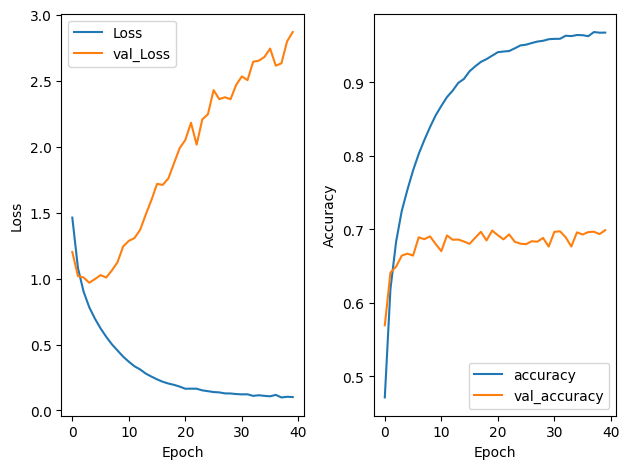

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
evaluation = model.evaluate(X_test, y_test)
print(f'Accuracy on test set : {evaluation[1] * 100:.2f}%')
print(f'Loss on test set : {evaluation[0] * 100:.2f}%')

<IPython.core.display.Javascript object>

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7009 - loss: 2.7911
Accuracy on test set : 69.89%
Loss on test set : 286.76%


Adding a convolutional block improves the accuracy to ~70%.   
However, the model is more complex and still suffers from significant overfitting, similar to the base model.

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
Image 3264 is a(n) dog and the model predicts that it's a(n) airplane


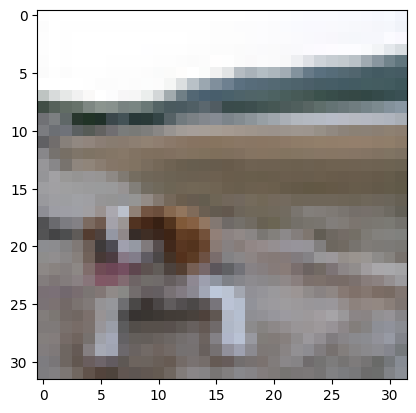

In [ ]:
index = np.random.randint(0, len(X_test))
image = X_test[index]
prediction = np.argmax(model.predict(image.reshape(1, 32, 32, 3)))
plt.imshow(image)

print(f"Image {index} is a(n) {labels[np.argmax(y_test[index])]} and the model predicts that it's a(n) {labels[prediction]}")

### Model 3: Dropout

The previous models show signs of overfitting.   
We add Dropout layers to improve the model's generalization by randomly "turning off" some neurons during training.

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
model.summary()

<IPython.core.display.Javascript object>

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,786 (1.04 MB)

 Trainable params: 271,786 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=40,
    validation_data=(X_test, y_test),
)



<IPython.core.display.Javascript object>

Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3400 - loss: 1.7866 - val_accuracy: 0.5745 - val_loss: 1.1889
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5725 - loss: 1.1944 - val_accuracy: 0.6438 - val_loss: 1.0049
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6385 - loss: 1.0238 - val_accuracy: 0.6747 - val_loss: 0.9196
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6795 - loss: 0.9108 - val_accuracy: 0.6996 - val_loss: 0.8629
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7069 - loss: 0.8347 - val_accuracy: 0.7184 - val_loss: 0.8021
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7242 - loss: 0.7810 - val_accuracy: 0.7214 - val_loss: 0.7964
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7424 - loss: 0.7314 - val_accuracy: 0.7388 - val_loss: 0.7582
Epoch 8/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7534 - loss: 0.6911 -

<IPython.core.display.Javascript object>

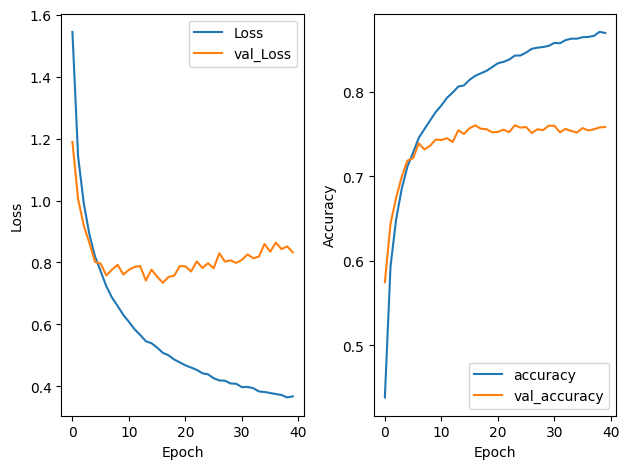

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
evaluation = model.evaluate(X_test, y_test)
print(f'Accuracy on test set : {evaluation[1] * 100:.2f}%')
print(f'Loss on test set : {evaluation[0] * 100:.2f}%')

<IPython.core.display.Javascript object>

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7646 - loss: 0.8154
Accuracy on test set : 75.83%
Loss on test set : 83.28%


Introducing dropout layers significantly reduces overfitting, leading to a better validation accuracy of ~76%.   
The model now generalizes better to unseen data, as seen by the smaller gap between the training and validation curves.

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Image 4859 is a(n) frog and the model predicts that it's a(n) frog


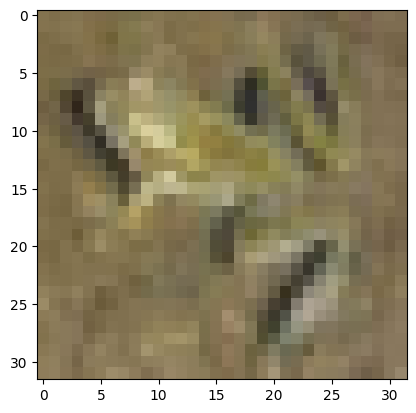

In [ ]:
index = np.random.randint(0, len(X_test))
image = X_test[index]
prediction = np.argmax(model.predict(image.reshape(1, 32, 32, 3)))
plt.imshow(image)

print(f"Image {index} is a(n) {labels[np.argmax(y_test[index])]} and the model predicts that it's a(n) {labels[prediction]}")

### Model 4:Adding L2 Regularization

We combine the previous techniques with L2 weight regularization

In [ ]:
kernel = (3, 3)
weight_decay = 1e-4

model = Sequential()


model.add(Conv2D(32, kernel_size=kernel, padding='same', kernel_regularizer=l2(weight_decay), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=kernel, padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=kernel, padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=kernel, padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=kernel, padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(Conv2D(128, kernel_size=kernel, padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, kernel_size=kernel, padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=kernel, padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
model.summary()

<IPython.core.display.Javascript object>

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             

 Total params: 1,206,442 (4.60 MB)

 Trainable params: 1,206,442 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=40,
    validation_data=(X_test, y_test),
)

<IPython.core.display.Javascript object>

Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.2193 - loss: 2.0809 - val_accuracy: 0.4066 - val_loss: 1.5668
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4144 - loss: 1.5846 - val_accuracy: 0.5047 - val_loss: 1.4045
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5094 - loss: 1.3965 - val_accuracy: 0.5851 - val_loss: 1.2058
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5690 - loss: 1.2716 - val_accuracy: 0.6255 - val_loss: 1.1164
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6042 - loss: 1.1874 - val_accuracy: 0.6641 - val_loss: 1.0305
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6313 - loss: 1.1224 - val_accuracy: 0.6590 - val_loss: 1.0385
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6526 - loss: 1.0804 - val_accuracy: 0.6859 - val_loss: 0.9797
Epoch 8/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6704 - loss: 1.0486 

<IPython.core.display.Javascript object>

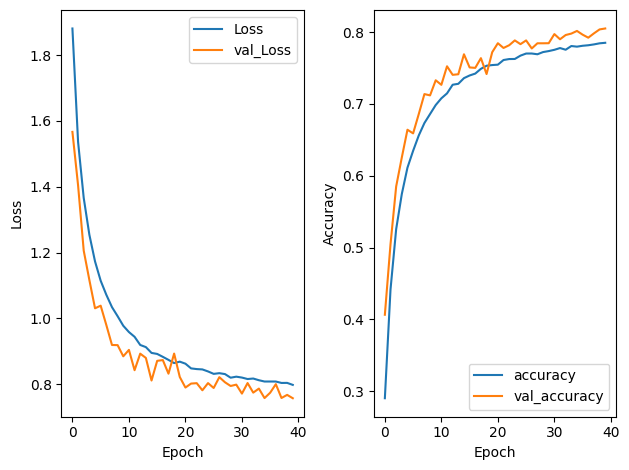

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
evaluation = model.evaluate(X_test, y_test)
print(f'Accuracy on test set : {evaluation[1] * 100:.2f}%')
print(f'Loss on test set : {evaluation[0] * 100:.2f}%')

<IPython.core.display.Javascript object>

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8028 - loss: 0.7661
Accuracy on test set : 80.50%
Loss on test set : 75.71%


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
Image 9225 is a(n) dog and the model predicts that it's a(n) ship


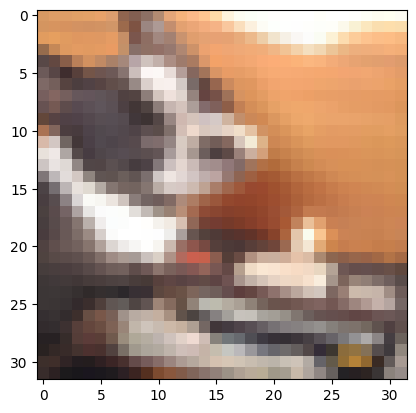

In [ ]:
index = np.random.randint(0, len(X_test))
image = X_test[index]
prediction = np.argmax(model.predict(image.reshape(1, 32, 32, 3)))
plt.imshow(image)

print(f"Image {index} is a(n) {labels[np.argmax(y_test[index])]} and the model predicts that it's a(n) {labels[prediction]}")

In this case the random prediction is false, but the accuracy is increase over the 80%

## FINAL MODEL BEFORE FINE TUNING

As a final step before transfer learning, we add Batch Normalization after each convolutional layer. This technique stabilizes and accelerates training. We also add data augmentation during training.

In [ ]:
kernel = (3, 3)
weight_decay = 1e-4

model = Sequential()

model.add(Conv2D(32, kernel_size=kernel, padding='same', kernel_regularizer=l2(weight_decay), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=kernel, padding='same', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=kernel, padding='same', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=kernel, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=kernel, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, kernel_size=kernel, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, kernel_size=kernel, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=kernel, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])




<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

<IPython.core.display.Javascript object>

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             

 Total params: 1,210,282 (4.62 MB)

 Trainable params: 1,208,362 (4.61 MB)

 Non-trainable params: 1,920 (7.50 KB)

We add simple data augmentation techniques and an early stopper based on

---

validation loss and patience of 5 epochs.

In [ ]:
new_data = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True
)

batch_size = 32
train_data = new_data.flow(X_train, y_train, batch_size=batch_size)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    epochs=40,
    validation_data=(X_test, y_test),
    callbacks=[callback]
)


<IPython.core.display.Javascript object>

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - accuracy: 0.3315 - loss: 1.9255 - val_accuracy: 0.4948 - val_loss: 1.5673
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.5377 - loss: 1.3511 - val_accuracy: 0.5936 - val_loss: 1.1856
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.6148 - loss: 1.1446 - val_accuracy: 0.6269 - val_loss: 1.1006
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.6630 - loss: 1.0233 - val_accuracy: 0.6993 - val_loss: 0.9238
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.6918 - loss: 0.9399 - val_accuracy: 0.7038 - val_loss: 0.9076
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.7082 - loss: 0.9016 - val_accuracy: 0.7323 - val_loss: 0.8333
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.7339 - loss: 0.8397 - val_accuracy: 0.7434 - val_loss: 0.8208
Epoch 8/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.7418 - loss: 0.82

# Evaluation

<IPython.core.display.Javascript object>

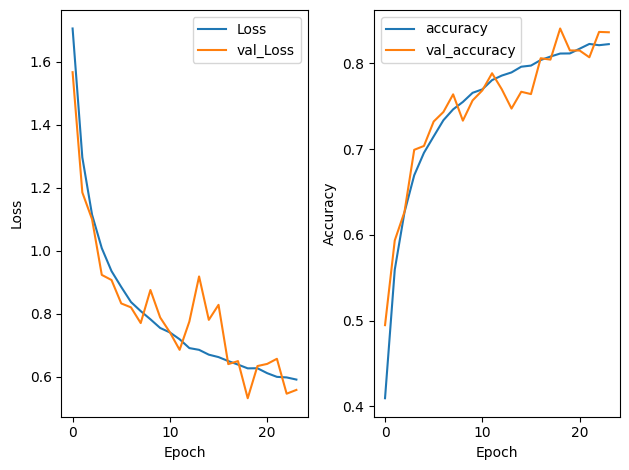

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
evaluation = model.evaluate(X_test, y_test)
print(f'Accuracy on test set : {evaluation[1] * 100:.2f}%')
print(f'Loss on test set : {evaluation[0] * 100:.2f}%')

<IPython.core.display.Javascript object>

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8412 - loss: 0.5307
Accuracy on test set : 84.08%
Loss on test set : 53.24%


The model is much more stable, though there is still room for improvement.

# Testing the prediction

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image 3720 is a(n) bird and the model predicts that it's a(n) bird


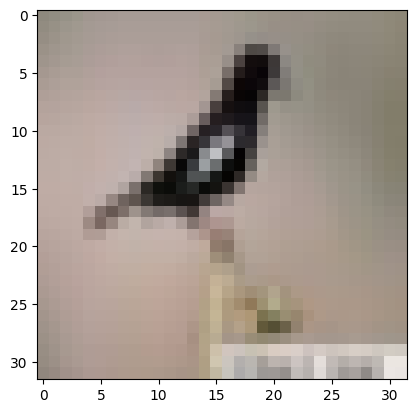

In [ ]:
index = np.random.randint(0, len(X_test))
image = X_test[index]
prediction = np.argmax(model.predict(image.reshape(1, 32, 32, 3)))
plt.imshow(image)

print(f"Image {index} is a(n) {labels[np.argmax(y_test[index])]} and the model predicts that it's a(n) {labels[prediction]}")

# Evaluation for each category


We evaluate the final pre-tuning model more deeply by generating a classification report and a confusion matrix to analyze its performance on each individual class.


For each category we display in addition to accuracy, precision, recall and fl-score index.  

Legend:

- **Precision**: Of all the times the model predicted a class (e.g., "cat"), how many times was it right?
- **Recall (Class Accuracy)**: Of all the images that were actually of a class (e.g., all real cats), how many did the model correctly identify? **This is the accuracy per single category.**
- **F1-score**: A weighted average between Precision and Recall. Useful for having a single value that summarizes the performance of a class.
- **Support**: The number of actual samples for each class in the test set.







In [ ]:
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

report = classification_report(y_true_labels, y_pred_labels, target_names=labels)
print(report)

<IPython.core.display.Javascript object>

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

    airplane       0.80      0.91      0.85      1000
  automobile       0.96      0.91      0.94      1000
        bird       0.89      0.68      0.77      1000
         cat       0.80      0.61      0.69      1000
        deer       0.81      0.84      0.82      1000
         dog       0.78      0.76      0.77      1000
        frog       0.81      0.92      0.86      1000
       horse       0.80      0.93      0.86      1000
        ship       0.94      0.89      0.91      1000
       truck       0.86      0.95      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



<IPython.core.display.Javascript object>

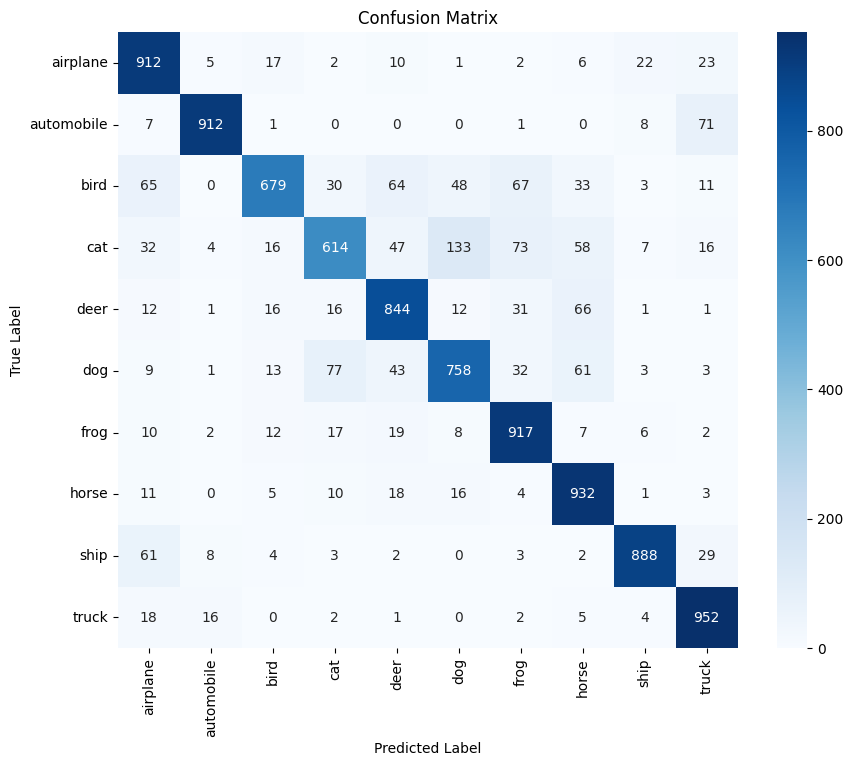

In [ ]:
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
model.save('cnn_fdl.keras')

<IPython.core.display.Javascript object>

### Fine tuning: Final model

Fine tuning is used to further improve performance.  
In particular, ResNet50, considered one of the best networks for this kind of task, will be used.  
Training with ResNet50 will require upscaling the images to a size of 224x224.   
This modification will be performed ‘on the fly,’ that is, in batch.  
AUTOTUNE will be used to optimize performance automatically.

The fine tuning will be done in two phases.   
In the first phase only the final dense layer will be trained, instead in the second one the whole network, but with a very low learning rate.

We also add three augmentation techinques:

zoom, contrast and cutmix.

With these techniques, the classifier avoids solving the task by exploiting edge vividness (contrast), image-background proportions (zoom), or by inspecting only a small region of the image (cutmix).

In [ ]:

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])




<IPython.core.display.Javascript object>

In [ ]:
def cutmix(image, label):


    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)

    # Create a shuffled batch to mix with
    indices = tf.random.shuffle(tf.range(tf.shape(image)[0]))
    shuffled_image = tf.gather(image, indices)
    shuffled_label = tf.gather(label, indices)

    # Get the mixing ratio and bounding box
    lam = tf.random.uniform(shape=(), minval=0.0, maxval=1.0, dtype=tf.float32)
    target_h = tf.cast(tf.shape(image)[1], dtype=tf.float32)
    target_w = tf.cast(tf.shape(image)[2], dtype=tf.float32)
    ratio = tf.math.sqrt(1.0 - lam)

    cut_h = tf.cast(ratio * target_h, dtype=tf.int32)
    cut_w = tf.cast(ratio * target_w, dtype=tf.int32)

    cx = tf.random.uniform(shape=(), maxval=tf.cast(target_w, dtype=tf.int32), dtype=tf.int32)
    cy = tf.random.uniform(shape=(), maxval=tf.cast(target_h, dtype=tf.int32), dtype=tf.int32)

    x1 = tf.clip_by_value(cx - cut_w // 2, 0, tf.cast(target_w, dtype=tf.int32))
    y1 = tf.clip_by_value(cy - cut_h // 2, 0, tf.cast(target_h, dtype=tf.int32))
    x2 = tf.clip_by_value(cx + cut_w // 2, 0, tf.cast(target_w, dtype=tf.int32))
    y2 = tf.clip_by_value(cy + cut_h // 2, 0, tf.cast(target_h, dtype=tf.int32))

    # Create the patch and the mask
    patch = shuffled_image[:, y1:y2, x1:x2, :]
    mask = tf.pad(tf.ones_like(patch), [[0, 0], [y1, tf.shape(image)[1] - y2], [x1, tf.shape(image)[2] - x2], [0, 0]])

    # Mix the images
    mixed_image = (1.0 - mask) * image + mask * tf.pad(patch, [[0, 0], [y1, tf.shape(image)[1] - y2], [x1, tf.shape(image)[2] - x2], [0, 0]])

    # Mix the labels
    area = tf.cast((x2 - x1) * (y2 - y1), dtype=tf.float32)
    lam_adjusted = 1.0 - (area / (target_h * target_w))

    mixed_label = lam_adjusted * label + (1.0 - lam_adjusted) * shuffled_label

    return mixed_image, mixed_label


In [ ]:
# --- Preprocessing Functions ---
def preprocess_and_augment(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = data_augmentation(image, training=True)
    image = keras.applications.resnet50.preprocess_input(image)
    return image, label

def preprocess_test(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = keras.applications.resnet50.preprocess_input(image)
    return image, label



changin early stopping rules and adding dynamic learning rate

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)


reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_delta=0.001,
    verbose=1
)

In [ ]:
# --- Data Loading ---
print("Loading CIFAR-10 dataset...")
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = keras.datasets.cifar10.load_data()

y_train_ft_one_hot = keras.utils.to_categorical(y_train_orig, 10)
y_test_ft_one_hot = keras.utils.to_categorical(y_test_orig, 10)

# --- Data Pipeline Creation ---
print("Creating data pipelines...")
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_orig, y_train_ft_one_hot))
train_dataset_ft = (
    train_dataset
    .shuffle(BATCH_SIZE * 100)
    .map(preprocess_and_augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(cutmix, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_orig, y_test_ft_one_hot))
test_dataset_ft = (
    test_dataset
    .map(preprocess_test, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
print("Pipelines successfully created.")

# --- Model Building ---
print("\nBuilding model with ResNet50 base...")
base_model_ft = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model_ft.trainable = False
model_ft = Sequential([
    base_model_ft,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
print("\nFine-Tuning model architecture:")
model_ft.summary()


print("\n--- STEP 1: CLASSIFIER HEAD TRAINING ---")
model_ft.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history_ft1 = model_ft.fit(train_dataset_ft, epochs=50, validation_data=test_dataset_ft, callbacks=[early_stopping_callback, reduce_lr_callback])


print("\n--- STEP 2: COMPLETE MODEL FINE-TUNING ---")
base_model_ft.trainable = True
model_ft.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])
history_ft2 = model_ft.fit(train_dataset_ft, epochs=50, validation_data=test_dataset_ft, callbacks=[early_stopping_callback, reduce_lr_callback], initial_epoch=history_ft1.epoch[-1] + 1)

Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Creating data pipelines...
Pipelines successfully created.

Building model with ResNet50 base...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Fine-Tuning model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- STEP 1: CLASSIFIER HEAD TRAINING ---
Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 157s 92ms/step - accuracy: 0.4298 - loss: 1.9236 - val_accuracy: 0.8411 - val_loss: 0.5057 - learning_rate: 0.0010
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 133s 85ms/step - accuracy: 0.5313 - loss: 1.6466 - val_accuracy: 0.8387 - val_loss: 0.4952 - learning_rate: 0.0010
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 133s 85ms/step - accuracy: 0.5406 - loss: 1.6376 - val_accuracy: 0.8375 - val_loss: 0.4909 - learning_rate: 0.0010
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 133s 85ms/step - accuracy: 0.5317 - loss: 1.6474 - val_accuracy: 0.8608 - val_loss: 0.4451 - learning_rate: 0.0010
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 133s 85ms/step - accuracy: 0.5356 - loss: 1.6366 - val_accuracy: 0.8519 - val_loss: 0.4601 - learning_rate: 0.0010
Epoch 6/50
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5335 - loss: 1.6439
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1563/15


--- FINAL EVALUATION ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9680 - loss: 0.1504
Accuracy on test set : 96.70%
Loss on test set: 15.18%


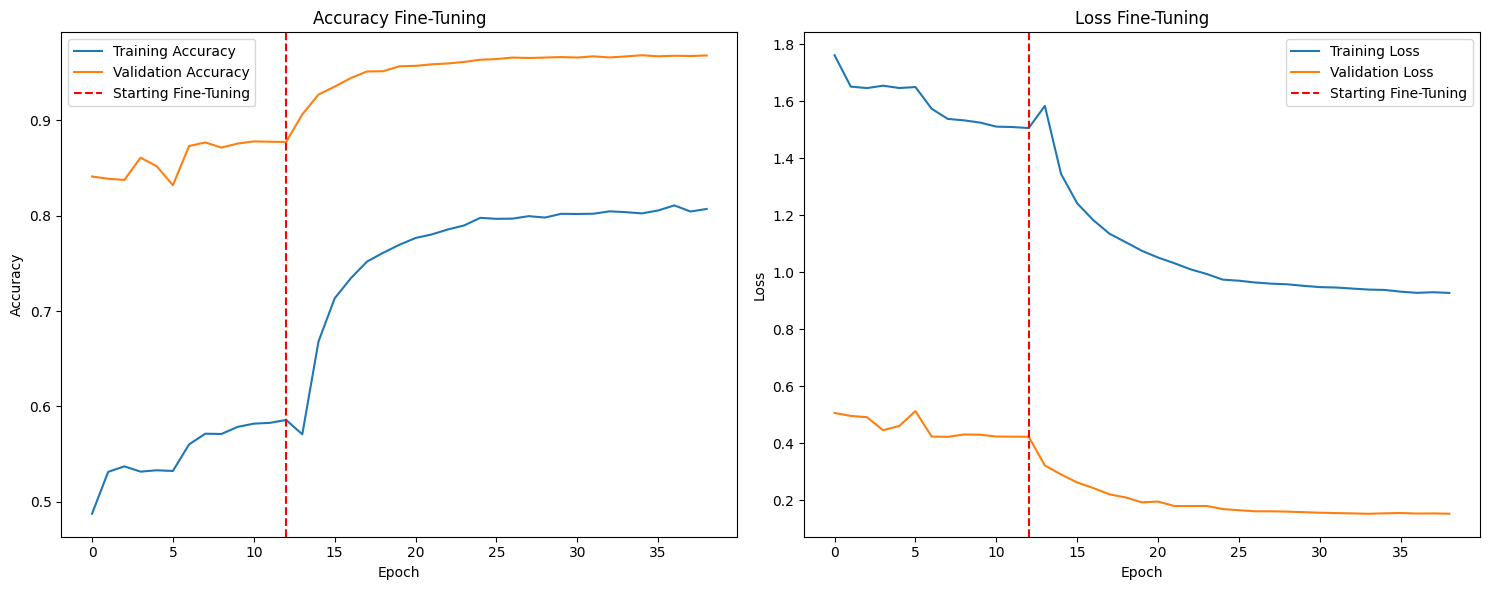

In [ ]:
# --- FINAL EVALUATION ---
print("\n--- FINAL EVALUATION ---")
evaluation_ft = model_ft.evaluate(test_dataset_ft)
print(f'Accuracy on test set : {evaluation_ft[1] * 100:.2f}%')
print(f'Loss on test set: {evaluation_ft[0] * 100:.2f}%')

# --- Plotting Learning Curves ---
acc = history_ft1.history['accuracy'] + history_ft2.history['accuracy']
val_acc = history_ft1.history['val_accuracy'] + history_ft2.history['val_accuracy']
loss = history_ft1.history['loss'] + history_ft2.history['loss']
val_loss = history_ft1.history['val_loss'] + history_ft2.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=len(history_ft1.history['accuracy'])-1, color='r', linestyle='--', label='Starting Fine-Tuning')
plt.title('Accuracy Fine-Tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=len(history_ft1.history['loss'])-1, color='r', linestyle='--', label='Starting Fine-Tuning')
plt.title('Loss Fine-Tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()



--- RANDOM IMAGE TEST ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image 9845 is 'truck' and model predict is 'truck'


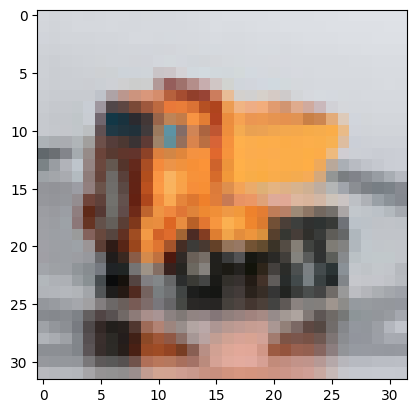

In [ ]:
# --- RANDOM IMAGE TEST ---
print("\n--- RANDOM IMAGE TEST ---")

# Define labels if not already defined
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Assuming 'labels' list is defined in a previous cell
index = np.random.randint(0, len(x_test_orig))
image_to_show = x_test_orig[index]
label_to_show = y_test_orig[index]
image_resized = tf.image.resize(image_to_show, (IMG_SIZE, IMG_SIZE))
image_preprocessed = keras.applications.resnet50.preprocess_input(image_resized)
image_to_predict = tf.expand_dims(image_preprocessed, axis=0)
prediction = np.argmax(model_ft.predict(image_to_predict))
plt.imshow(image_to_show)
print(f"Image {index} is '{labels[label_to_show[0]]}' and model predict is '{labels[prediction]}'")

In [ ]:
model_ft.save('cnn_transfer_learning_final.keras')

The final classification report and confusion matrix show excellent performance across almost all categories.


 Prediction on test set for each class...
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step

True labels extraction...


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

    airplane       0.98      0.97      0.98      1000
  automobile       0.98      0.98      0.98      1000
        bird       0.97      0.97      0.97      1000
         cat       0.95      0.90      0.93      1000
        deer       0.96      0.98      0.97      1000
         dog       0.94      0.94      0.94      1000
        frog       0.97      0.99      0.98      1000
       horse       0.97      0.98      0.98      1000
        ship       0.97      0.99      0.98      1000
       truck       0.97      0.97      0.97      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



--- CONFUSION MATRIX ---



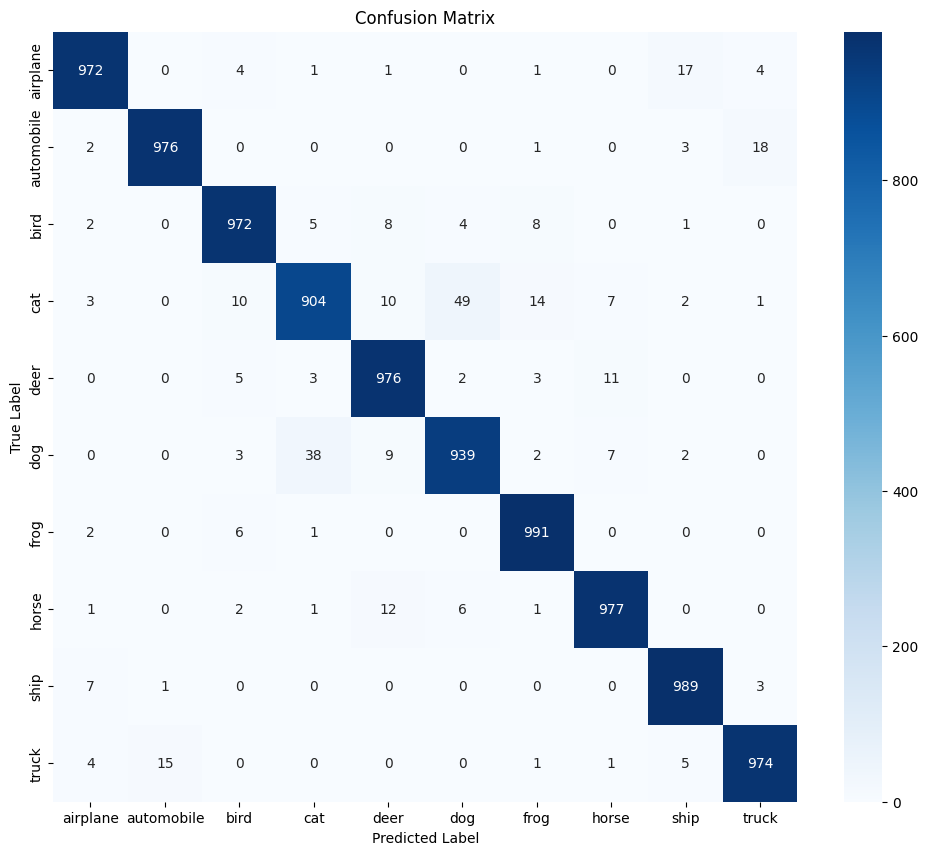

In [ ]:
print("\n Prediction on test set for each class...")
y_pred_probs = model_ft.predict(test_dataset_ft)


y_pred_labels = np.argmax(y_pred_probs, axis=1)


print("\nTrue labels extraction...")

y_true_labels_one_hot = np.concatenate([y for x, y in test_dataset_ft], axis=0)
y_true_labels = np.argmax(y_true_labels_one_hot, axis=1)


print("\n\n--- CLASSIFICATION REPORT ---")
report = classification_report(y_true_labels, y_pred_labels, target_names=labels)
print(report)


print("\n\n--- CONFUSION MATRIX ---\n")

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Thanks to the fine tuning and data augmentation techniques employed the classifier can compete with a human reviewer.
Already in the first phase, the one with in which only the head was trained, the performance had reached 90 percent, but thanks to the retraining with low learning rate of ResNet50 the classifier achieved an accuracy of about 97 percent and an f-score of more than 97 percent for every category excluding dogs and cats.